In [1]:
!pip3 install pymc3==3.9.3
!pip3 install arviz==0.11.0
!pip3 install pymc
!pip3 install statsmodels

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import os
import sys
from plot_lib import set_default

set_default(figsize=(6, 4))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mixture models

istograms of data often reveal that they do not follow any standard probability distribution. Sometimes we have explanatory variables (or covariates) to account for the different values, and normally distributed errors are adequate, as in normal regression. However, if we only have the data values themselves and no covariates, we might have to fit a non-standard distribution to the data. One way to do this is by mixing standard distributions.

Mixture distributions are just a weighted combination of probability distribtuions. For example, we could take an exponential distribution with mean 1 and normal distribution with mean 3 and variance 1 (although typically the two mixture components would have the same support; here the exponential component has to be non-negative and the normal component can be positive or negative). Suppose we give them weights: 0.4 for the exponential distribution and 0.6 for the normal distribution. We could write the PDF for this distribution as 

$ p(y) = 0.4 \cdot \exp(-y) \cdot I_{(y \ge 0)} + 0.6 \cdot \frac{1}{\sqrt{2 \pi}} \exp\left(- \frac{1}{2} (y - 3)^2\right) \, $

The PDF of this mixture distribution would look like this:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


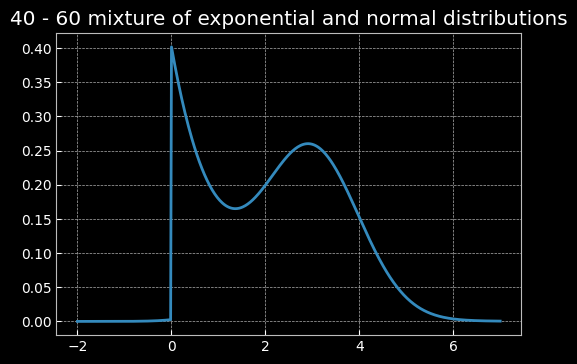

In [3]:
from scipy.stats import expon
from scipy.stats import norm

# Values to sample
x = np.linspace(-2, 7.0, num = 500)
# Exp distribution
lam = 1.0
r_exp = expon.pdf(scale = 1 / lam, x = x)
# Norm Distribution
mu = 3
var = 1
r_norm = norm.pdf(loc = mu, scale = 1 / (np.sqrt(var)), x = x)

### computing mixture model
mixture_model = (0.4 * r_exp) + (0.6 * r_norm)

# Plotting the mixture models
fig, ax = plt.subplots(1, 1)
sns.lineplot(x, mixture_model)
plt.title('40 - 60 mixture of exponential and normal distributions')
plt.show()

We could think of these two distributions as governing two distinct populations, one following the exponential distribution and the other following the normal distribution.

Let’s draw the weighted PDFs for each population.

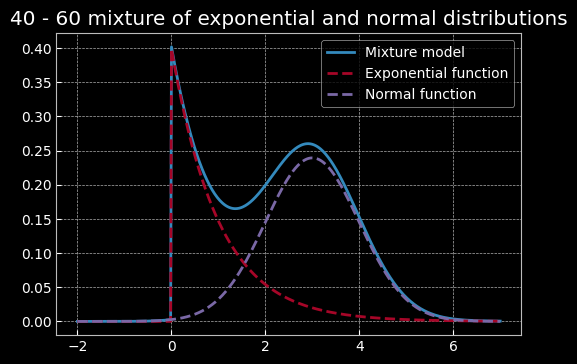

In [4]:
# Plotting the mixture models
fig, ax = plt.subplots(1, 1)
ax.plot(x, mixture_model, '-', label = 'Mixture model')
ax.plot(x, r_exp * 0.4, '--', label = 'Exponential function')
ax.plot(x, r_norm * 0.6, '--', label = 'Normal function')
plt.title('40 - 60 mixture of exponential and normal distributions')
plt.legend()
plt.show()

The general form for a discrete mixture of distributions is as follows: 

$ p(y) = \sum_{j=1}^J \omega_j \cdot f_j (y) $

where the $ω’s$ are positive weights that add up to 1 (they are probabilities) and each of the $J$ $f_j(y)$ functions is a PDF for some distribution. In the example above, the weights were 0.4 and 0.6, $f_1$ was an exponential PDF and $f_2$ was a normal PDF.

One way to simulate from a mixture distribution is with a hierarchical model. We first simulate an indicator for which “population” the next observation will come from using the weights $ω$. Let’s call this $z_i$. In the example above, $z_i$ would take the value 1 (indicating the exponential distribution) with probability 0.4 and 2 (indicating the normal distribution) with probability 0.6. Next, simulate the observation $y_i$ from the distribution corresponding to $z_i$.

Let’s simulate from our example mixture distribution.

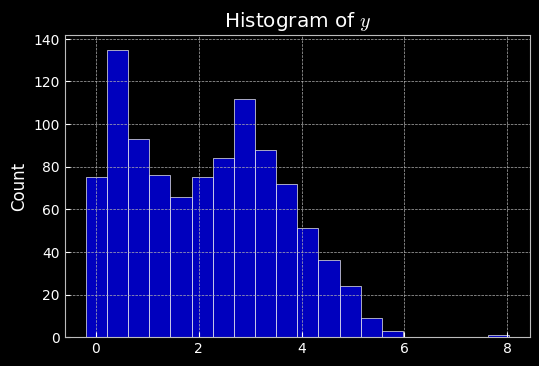

In [5]:
# Exp distribution
lam = 1.0
# Norm Distribution
mu = 3
var = 1

# variables
n = 1000
z = np.zeros(1000)
y = np.zeros(1000)
for i in range(n):
  z[i] = np.random.choice([1, 2], 1, p=[0.4, 0.6])
  if z[i] == 1:
    y[i] = expon.rvs(scale = 1 / lam, size = 1)
  if z[i] == 2:
    y[i] = norm.rvs(loc = mu, scale = 1 / (np.sqrt(var)), size = 1)

# Plotting the histogram of chips
fig, ax = plt.subplots(1, 1)
sns.histplot(y, stat= 'count', bins = 20)
plt.title('Histogram of $y$')
plt.show()

If we keep only the y values and throw away the $z$ values, we have a sample from the mixture model above. To see that they are equivalent, we can marginalize the joint distribution of $y$ and $z$:

$ p(y) = \sum_{j=1}^2 p(y, z=j) = \sum_{j=1}^2 p(z=j) \cdot p(y \mid z=j) = \sum_{j=1}^2 \omega_j \cdot f_j(y) \,$

### Bayesian inference for mixture models

When we fit a mixture model to data, we usually only have the $y$ values and do not know which “population” they belong to. Because the $z$ variables are unobserved, they are called latent variables. We can treat them as parameters in a hierarchical model and perform Bayesian inference for them. The hierarchial model might look like this: 

$ \begin{align}
y_i \mid z_i, \theta & \overset{\text{ind}}{\sim} f_{z_i}(y \mid \theta) \, , \quad i = 1, \ldots, n \\
\text{Pr}(z_i = j \mid \omega) &= \omega_j \, , \quad j=1, \ldots, J \\
\omega &\sim p(\omega) \\
\theta &\sim  p(\theta)
\end{align} $

where we might use a Dirichlet prior (see the review of distributions in the supplementary material) for the weight vector $ω$ and conjugate priors for the population-specific parameters in $θ$. With this model, we could obtain posterior distributions for $z$ (population membership of the observations), $ω$ (population weights), and $θ$ (population-specific parameters in $f_j$).

In [6]:
# Read dataset - mixture
mixture = pd.read_csv('mixture.csv', header=None, names = ['vals'])
# Checking dataframe
print("The shape of the dataset is: {}".format(mixture.shape))
mixture.head()

The shape of the dataset is: (200, 1)


,vals
0,-2.266175
1,0.883431
2,1.000343
3,1.019266
4,-3.222235


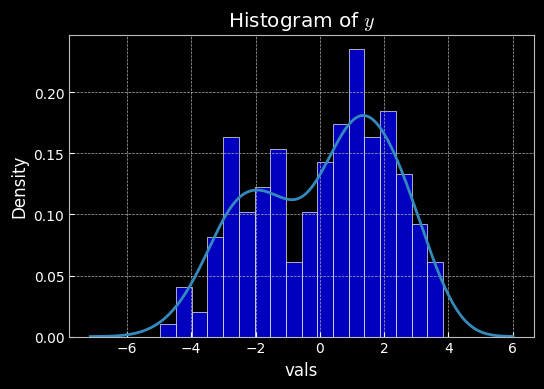

In [7]:
# Plotting the histogram of chips
fig, ax = plt.subplots(1, 1)
sns.histplot(mixture['vals'], stat= 'density', bins = 18)
sns.kdeplot(mixture['vals'], bw_adjust = 1.0, label = 'Density estimate $y$')
plt.title('Histogram of $y$')
plt.show()

It appears that we have two populations, but we do not know which population each observation belongs to. We can learn this, along with the mixture weights and population-specific parameters with a Bayesian hierarchical model.

We will use a mixture of two normal distributions with variance 1 and different (and unknown) means.



This shows us the distribution of the number of chips by different locations. It looks like maybe location five tends to be more generous on average than the others. 

Let's remind ourselves what this model looks like. We have the $i^{th}$ cookie from the $j^{th}$ location and $y_{ij}$ represents the number of chocolate chips in that cookie. Where $\lambda_j$ is the average or mean number of chips per cookie for location $j$. 

The different location means come from this gamma distribution with these hyper parameters. Before implementing the model, we need to select prior distributions for both $\alpha$ and $\beta$. First, think about what the lambdas represent. 

In location $j$ $\lambda_j$ is the expected number of chocolate chips per cookie. $\alpha$ and $\beta$ control the distribution for these means between locations. The mean of this gamma distribution will  represent the overall mean of number of chips for all cookies. The variance of this gamma distribution controls the variability between locations in the mean number of chips. If this variance is high, the mean number of chips will vary widely from location to location. If it is small, the mean number of chips will be nearly the same from location to location. 

This can be seen below:

$y_i \mid z_i, \mu, \sigma^2 \stackrel{ind}{\sim} \mathcal{N}{z_i}(y \mid \mu_j, \sigma^2) \, , \quad i = 1, \ldots, n \, , \quad j = 1, 2$

$z_i \sim \text{Categorical}(\omega) \, , \quad i = 1, \ldots, n$

$\omega_j \sim \text{Dirichlet}(1.0, 1.0) \, , \quad j = 1, 2$

$\sigma^2 \sim \text{InverseGamma}(1.0 / 2.0, (1.0 * 2.0) / 2.0)$

$\mu_1, \mu_2 \sim \mathcal{N}(\mu = [-1, 1], var = [100, 100]) \, , \quad \mu_1 < \mu_2  \, , \quad j = 1, 2$

Our latent variables $z[j]$ can be either a 1 or a 2. Depending on the probability of being 1 or 2 which is in our probability vector $\omega$. 

The Dirichlet distribution has a vector of shape parameters.
They're very similar to the beta shape parameters, where you add the number of counts to these alphas. To update a Dirichlet distribution just like you update a beta  distribution in the posterior. 

In [8]:
import theano.tensor as tt

Y = mixture['vals'].to_numpy()
n = Y.shape[0]

with pm.Model() as lr:
    ###  Definen priors of parameters
    k = 2 # Number of mixture models

    # Third level of parameters
    omg = pm.Dirichlet('omega', a = np.array([1.0, 1.0]), shape=k) # Concentration parameter, models probability
    # Of being in one group or another
    sig = pm.InverseGamma('sig', alpha = 1.0 / 2.0, beta = (1.0 * 1.0) / 2.0) # sig parameter

    # Second level of parameters
    mu = pm.Normal("mu", mu=[-1.0, 1.0], sigma = 100, shape = k)
    # break symmetry
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(mu[1] - mu[0] > 0, 0, -np.inf),) # ensures mu[0] < mu[1]
    # https://stackoverflow.com/questions/35823165/what-is-purpose-of-ifelse-and-switch-in-theano
    #  I would think of it as just another operator that acts on three symbolic variables, 
    # if the first is true, return the second, else return the third. 

    # latent cluster of each observation
    z = pm.Categorical("z", p = omg, shape = n)

    # Likelihood
    obs = pm.Normal('likelihood', mu = mu[z], sigma = sig, observed = Y)

In [9]:
with lr:
    # Use MCMC to sample 10000 samples
    trace = pm.sample(5000, tune = 1000, cores=4, init='adapt_diag')
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sig, omega]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 485 seconds.


### MCMC convergence diagnostic

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


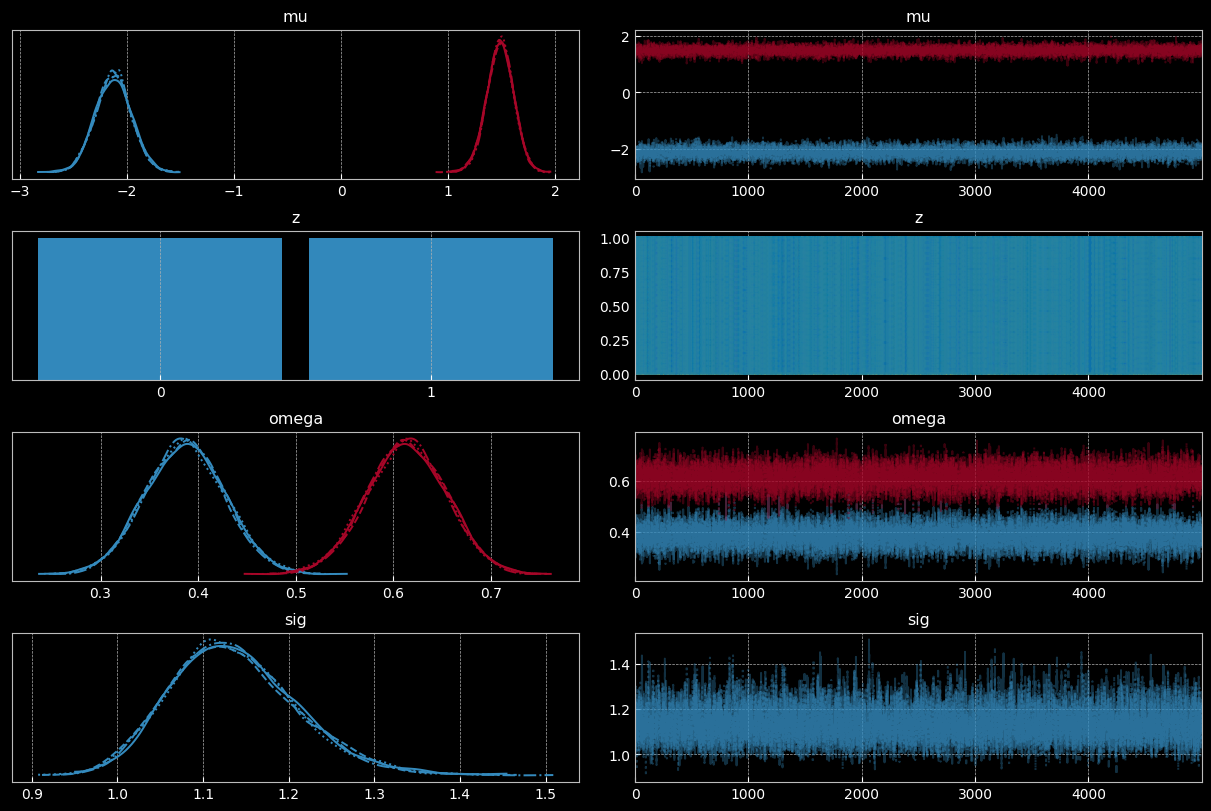

In [10]:
# Plotting posterior distributions
az.plot_trace(trace)
plt.show()

In [11]:
pm.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],-2.129,0.168,-2.453,-1.823,0.002,0.001,9668.0,9668.0,9673.0,12898.0,1.0
mu[1],1.487,0.126,1.253,1.728,0.001,0.001,9685.0,9685.0,9731.0,11629.0,1.0
z[0],0.010,0.101,0.000,0.000,0.001,0.001,13837.0,13837.0,13837.0,13837.0,1.0
z[1],0.977,0.150,1.000,1.000,0.001,0.001,14142.0,14142.0,14142.0,20000.0,1.0
z[2],0.982,0.132,1.000,1.000,0.001,0.001,13706.0,13706.0,13706.0,20000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
z[198],0.077,0.267,0.000,1.000,0.002,0.002,15223.0,15223.0,15223.0,15223.0,1.0
z[199],0.558,0.497,0.000,1.000,0.003,0.002,34369.0,34369.0,34369.0,20000.0,1.0
omega[0],0.387,0.040,0.310,0.462,0.000,0.000,11620.0,11620.0,11605.0,14373.0,1.0
omega[1],0.613,0.040,0.538,0.690,0.000,0.000,11620.0,11547.0,11605.0,14373.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


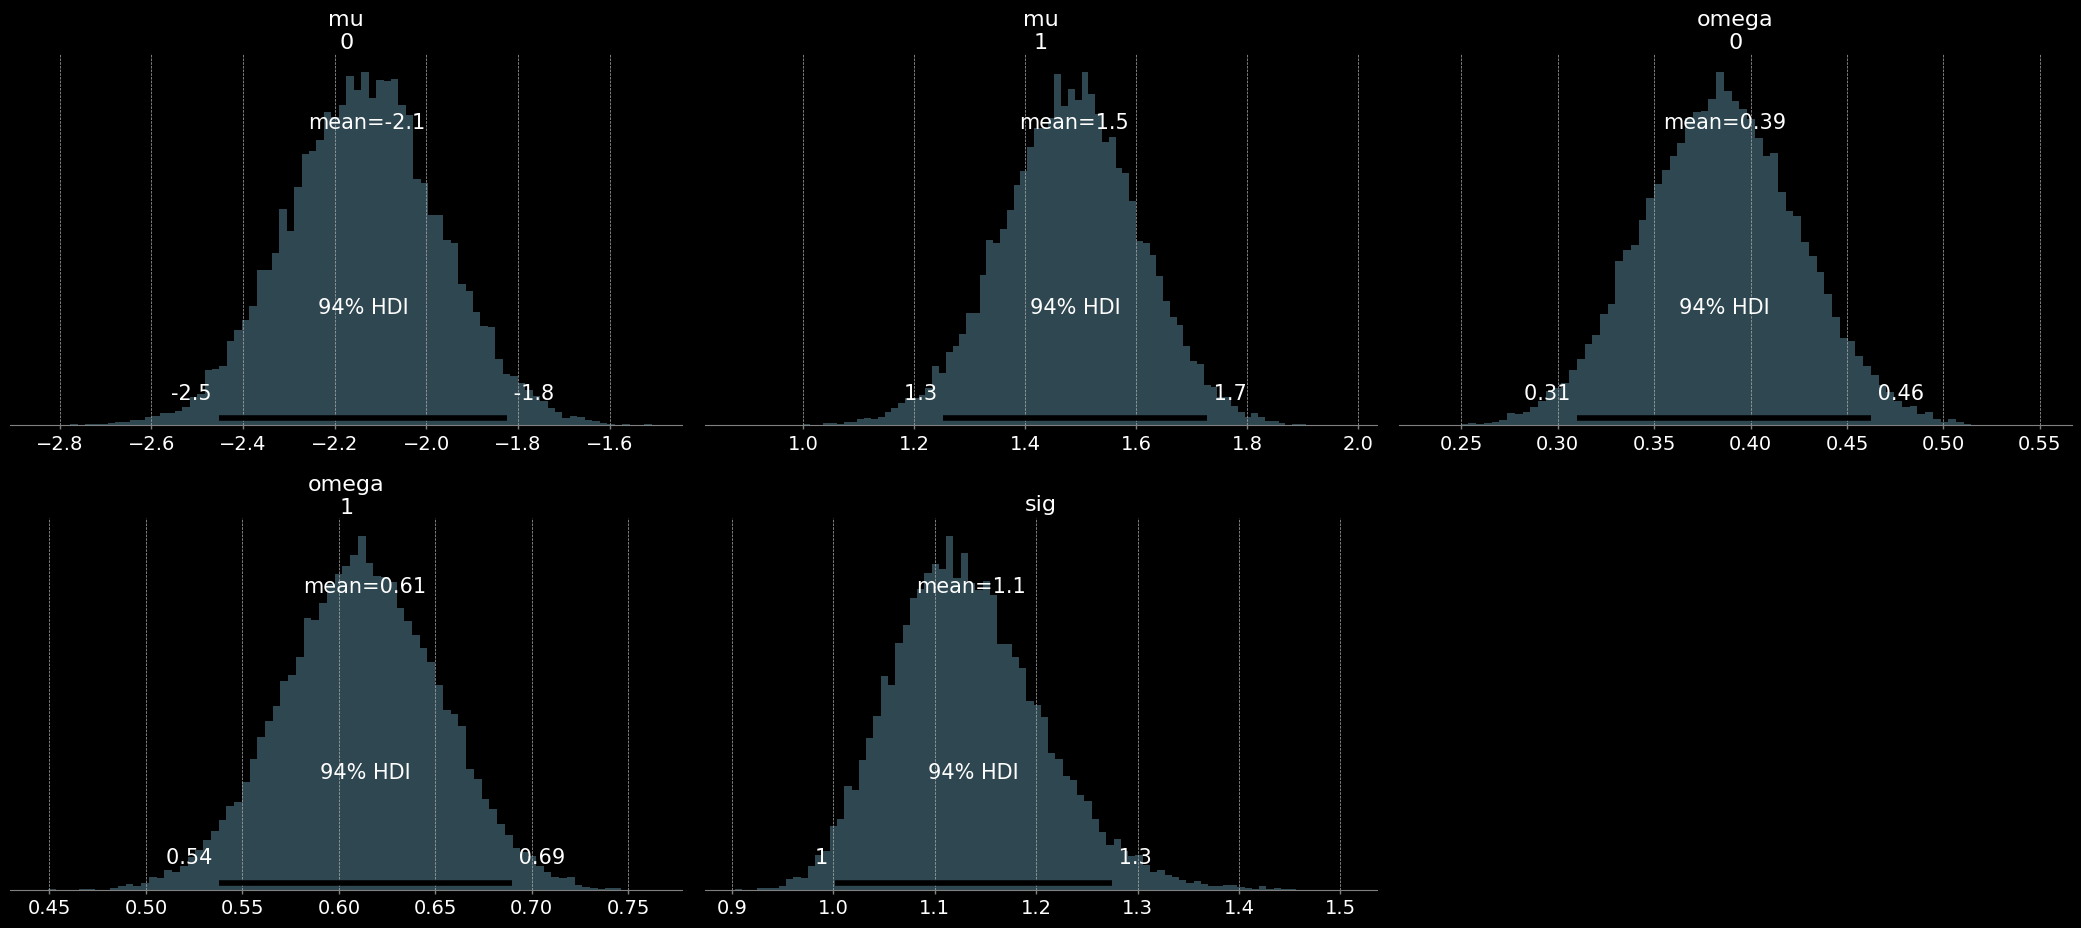

In [12]:
az.plot_posterior(trace, point_estimate = 'mean', kind = 'hist', color= "#87ceeb", var_names=["mu", "omega", "sig"])
plt.show()

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:496: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (200) in plot_posterior, generating only 40 plots
  UserWarning,


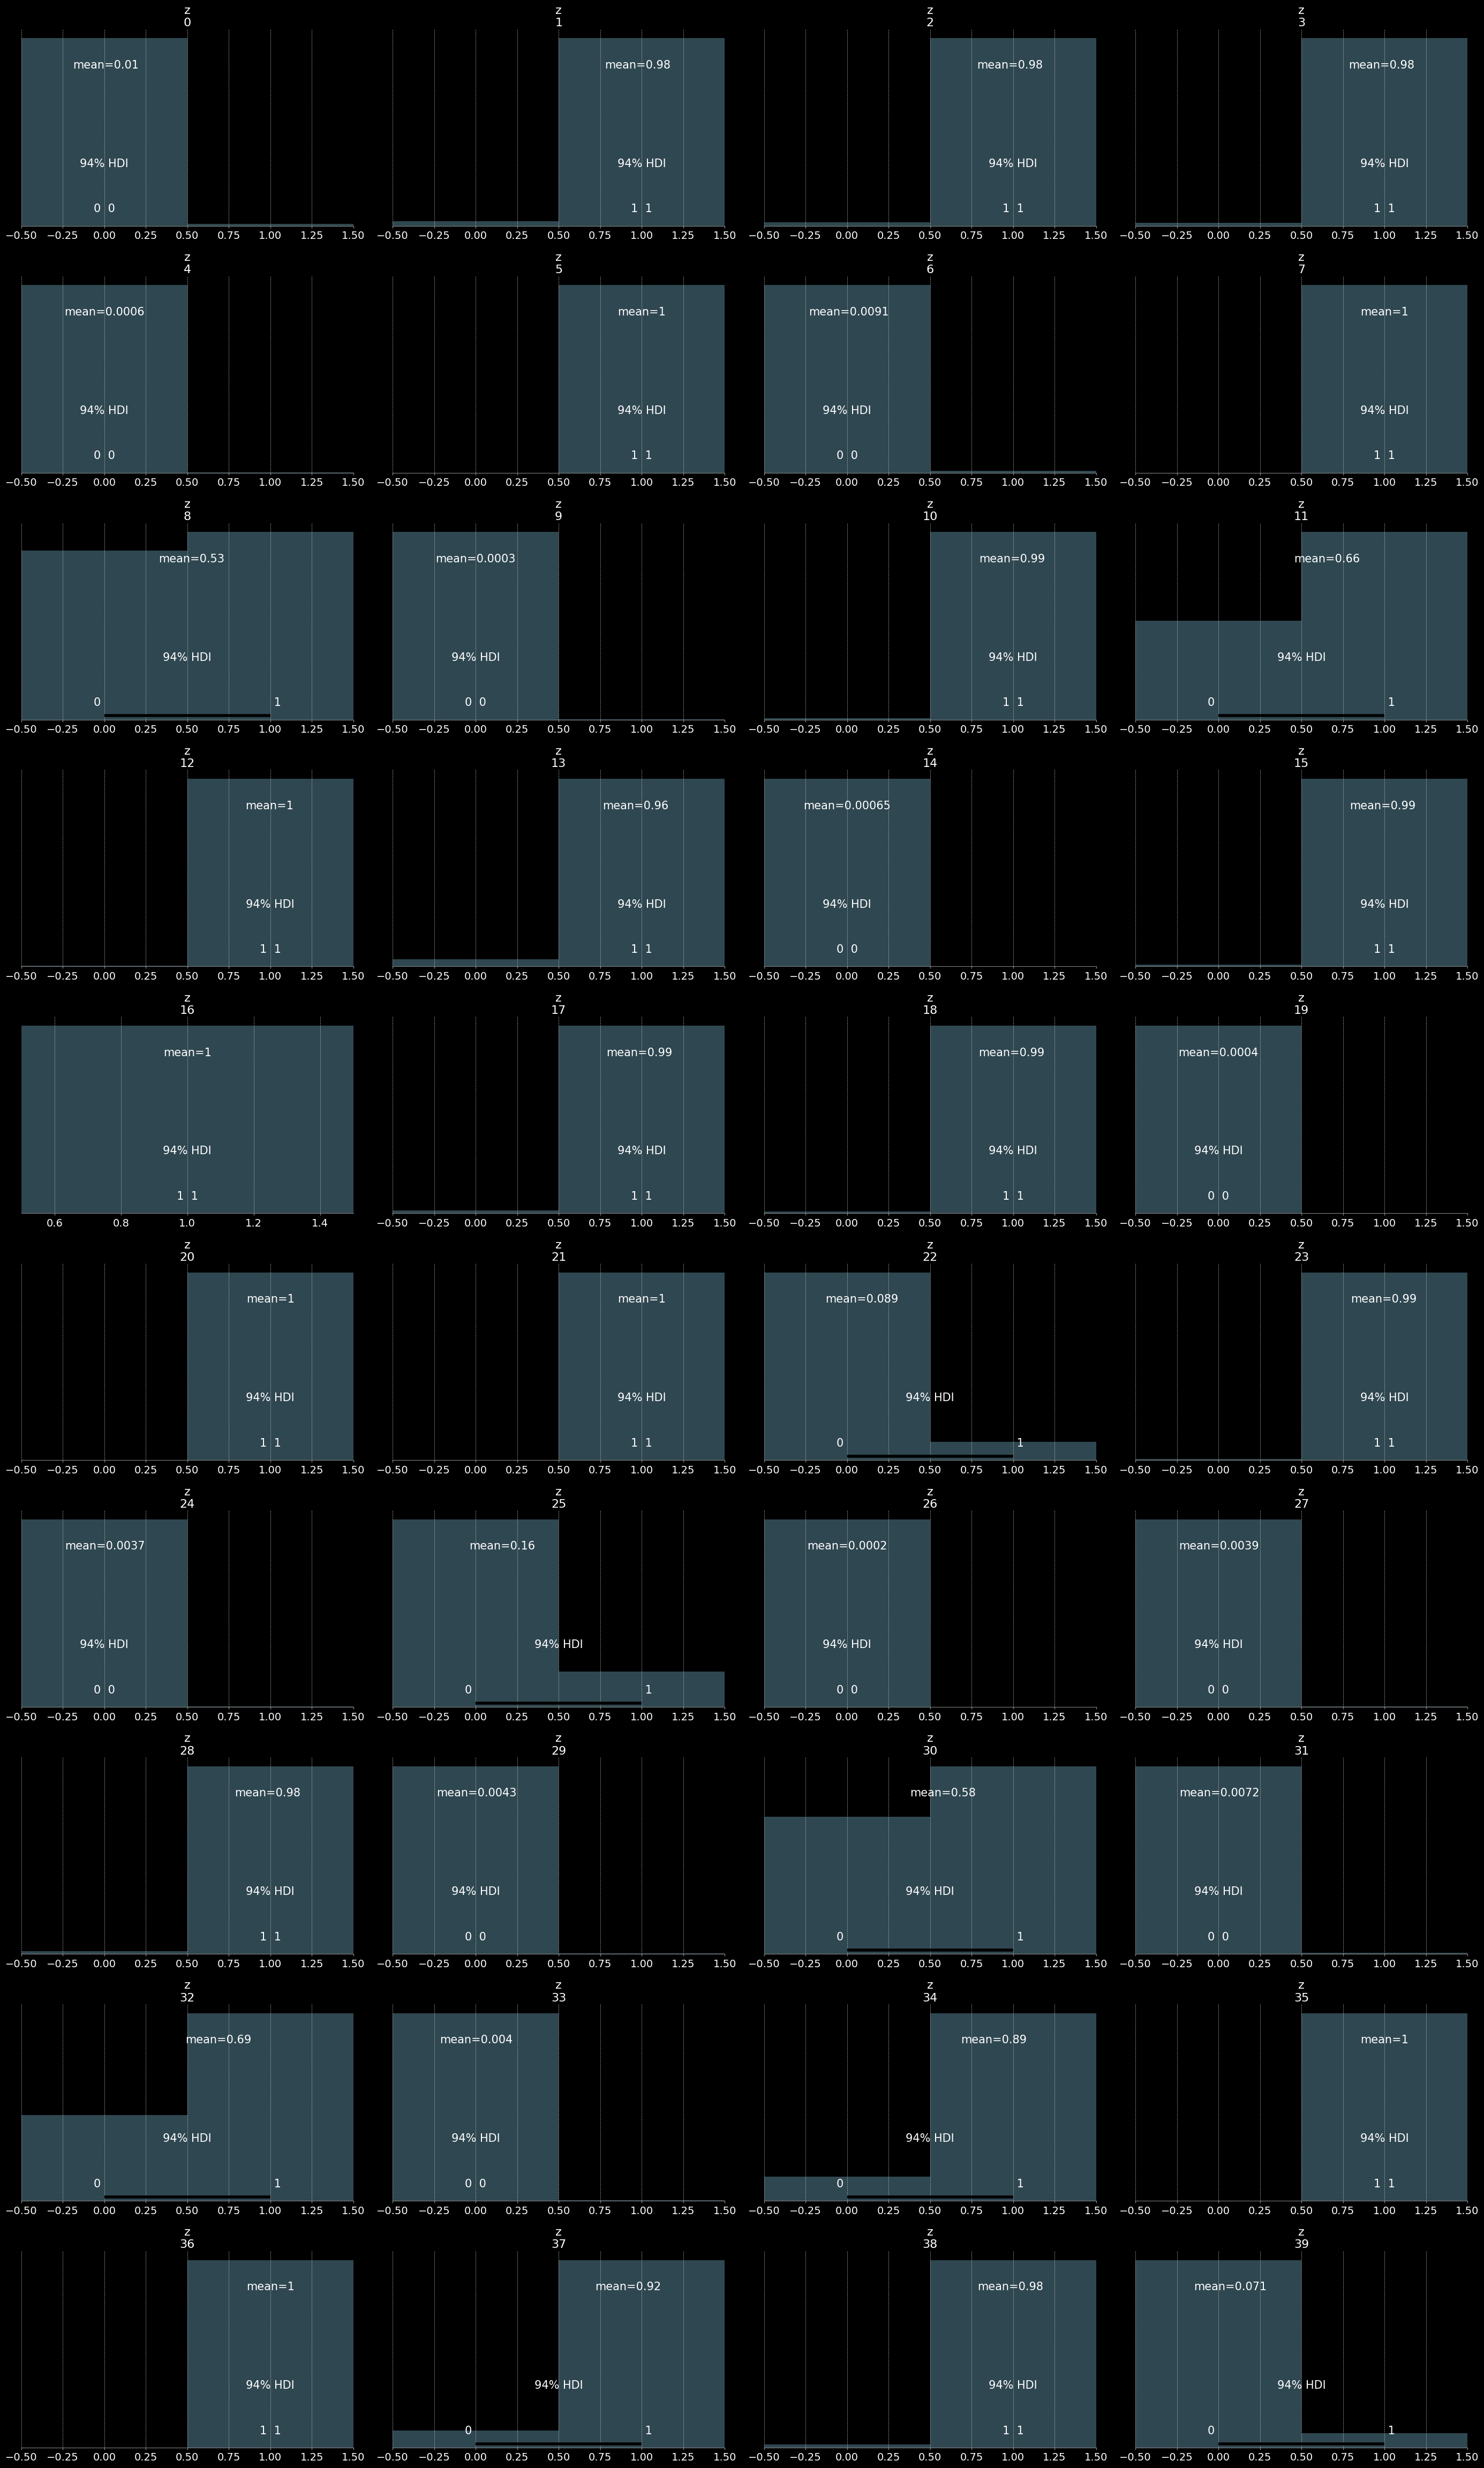

In [13]:
az.plot_posterior(trace, kind = 'hist', color= "#87ceeb", var_names=["z"])
plt.show()

Remember, the first observation associated with z[0] was very clearly in group 1, it was far over to the left. And you can see here, almost all of the posterior probability is that it is within group 1. Observation 30 was more ambiguous, we weren't sure which population it belonged to. The posterior distribution of z suggests that there's a little more posterior probability that it was in group two than in group one. 

In [14]:
# Sampling lambdas
with lr:
    posterior_params = pm.sample_posterior_predictive(trace, var_names=["z"])

In [15]:
# Plotting the predictions
latent_z = np.mean(posterior_params['z'], axis=0).ravel()

## posterior probabilities for z[1], the membership of y[1]
print('The value for the fist latent variable Z[0] for z = 1, is {} and for z = 2 is {}'.format(1 - latent_z[0], latent_z[0]))
print('The value for the fist latent variable Z[30] for z = 1, is {} and for z = 2 is {}'.format(1 - latent_z[30], latent_z[30]))
print('The value for the fist latent variable Z[49] for z = 1, is {} and for z = 2 is {}'.format(1 - latent_z[48], latent_z[48]))
print('The value for the fist latent variable Z[5] for z = 1, is {} and for z = 2 is {}'.format(1 - latent_z[5], latent_z[5]))

The value for the fist latent variable Z[0] for z = 1, is 0.9897 and for z = 2 is 0.0103
The value for the fist latent variable Z[30] for z = 1, is 0.4223 and for z = 2 is 0.5777
The value for the fist latent variable Z[49] for z = 1, is 0.1935 and for z = 2 is 0.8065
The value for the fist latent variable Z[5] for z = 1, is 4.999999999999449e-05 and for z = 2 is 0.99995


If we look back to the y values associated with these $z$ variables we monitored, we see that $y_0$ is clearly in Population $1’s$ territory, $y_30$ is ambiguous, $y_{48}$ is ambiguous but is closer to Population $2’s$ territory, and $y_6$ is clearly in Population $2’s$ territory. The posterior distributions for the z variables closely reflect our assessment.